## Importing and prepping data

In [1]:
import pandas as pd
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []
remote_folder = 'Gel_Studies/08_14_18_gel_validation' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
#vids = 10
sizes = [200, 500, 100]

counter = 0
for size in sizes:
    if size == 100:
        vids = 5
    else:
        vids = 10
    for num in range(1, vids+1):
        
        filename = 'features_{}nm_XY{}.csv'.format(size, '%02d' % num)
        aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name='ccurtis.data')
        fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        fstats['Particle Size'] = pd.Series(fstats.shape[0]*[size], index=fstats.index)
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
        counter = counter + 1
        if counter == 1:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)

In [ ]:
fstats_tot.to_csv('features.csv')

In [32]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
nonnum = ['Particle Size', 'Video Number', 'Track_ID']
fstats_num = fstats_tot.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [33]:
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=6)

Cumulative explained variance:
0 component: 0.3284770170102635
1 component: 0.47546191425087336
2 component: 0.6002549380864848
3 component: 0.6894421132900934
4 component: 0.7570781998988002
5 component: 0.8227641525344263


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [34]:
kmostat = pca.kmo(pcadataset.scaled)

0.942934030505


## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [35]:
import numpy as np
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']==100].as_matrix(), axis=0)[-6:]
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix(), axis=0)[-6:]
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix(), axis=0)[-6:]

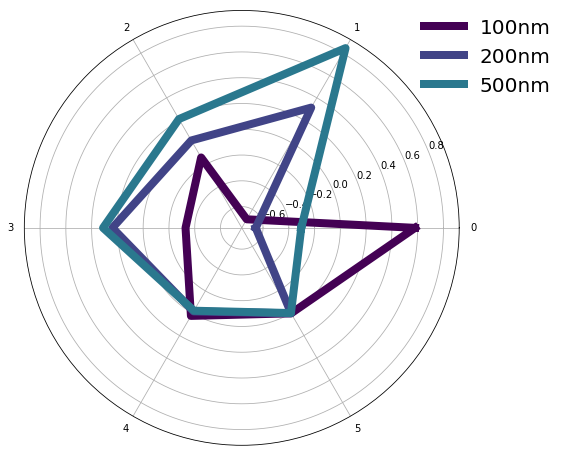

In [36]:
pca.plot_pca(dicti, savefig=True, labels=['100nm', '200nm', '500nm'])

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [37]:
pcadataset.prcomps

,0,1,2,3,4,5
0,alpha,kurtosis,elongation,AR,MSD_ratio,D_fit
1,Y,asymmetry2,frames,elongation,D_fit,MSD_ratio
2,asymmetry1,boundedness,kurtosis,fractal_dim,fractal_dim,fractal_dim
3,boundedness,asymmetry1,asymmetry2,X,AR,efficiency
4,efficiency,alpha,asymmetry3,efficiency,efficiency,AR


In [9]:
import numpy as np
dicti = {}
dicti[0] = np.nanstd(pcadataset.final[pcadataset.final['Particle Size']==100].as_matrix(), axis=0)[-6:]
dicti[1] = np.nanstd(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix(), axis=0)[-6:]
dicti[2] = np.nanstd(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix(), axis=0)[-6:]

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1308: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


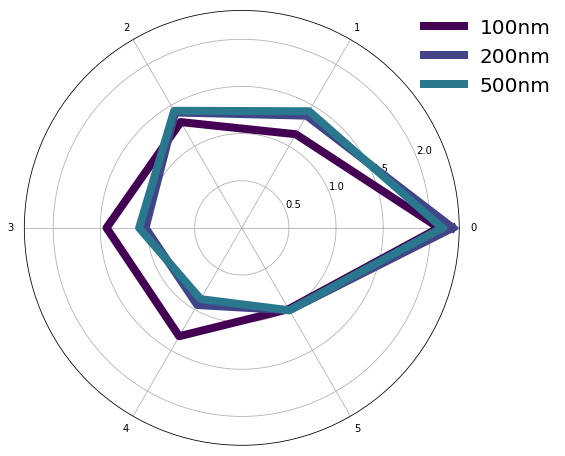

In [10]:
pca.plot_pca(dicti, savefig=True, labels=['100nm', '200nm', '500nm'])

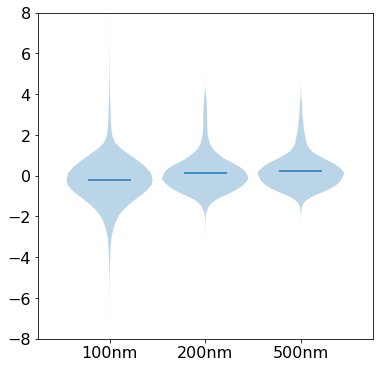

In [11]:
import diff_classifier.features as ft
tgroups = {}
tgroups[0] = pcadataset.final[pcadataset.final['Particle Size']==100]
tgroups[1] = pcadataset.final[pcadataset.final['Particle Size']==200]
tgroups[2] = pcadataset.final[pcadataset.final['Particle Size']==500]
ft.feature_violin(tgroups, points=160, feature=4, ylim=[-8, 8], labels=['100nm', '200nm', '500nm'], nticks=9)

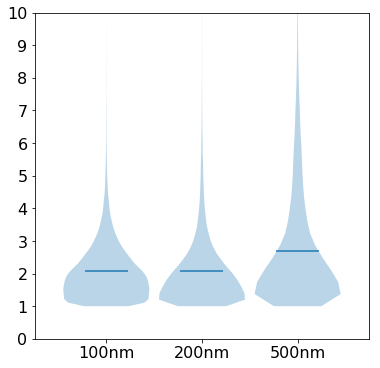

In [15]:
ft.feature_violin(tgroups, points=160, feature='AR', ylim=[0, 10], labels=['100nm', '200nm', '500nm'], nticks=11)

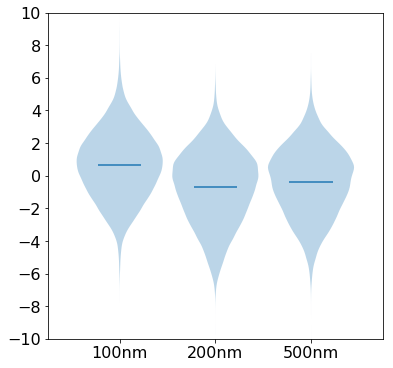

In [18]:
ft.feature_violin(tgroups, points=160, feature=0, ylim=[-10, 10], labels=['100nm', '200nm', '500nm'], nticks=11)

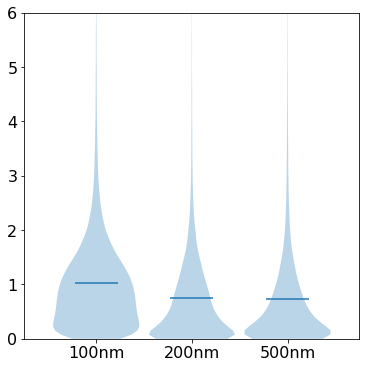

In [12]:
ft.feature_violin(tgroups, points=160, feature='alpha', ylim=[0, 6], labels=['100nm', '200nm', '500nm'], nticks=7)

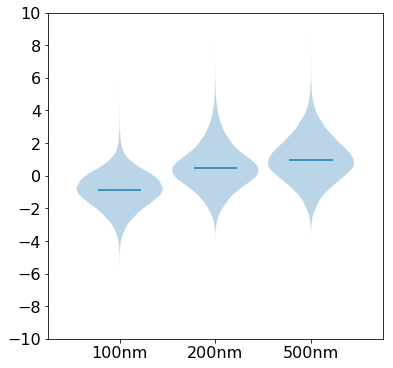

In [19]:
ft.feature_violin(tgroups, points=160, feature=1, ylim=[-10, 10], labels=['100nm', '200nm', '500nm'], nticks=11)

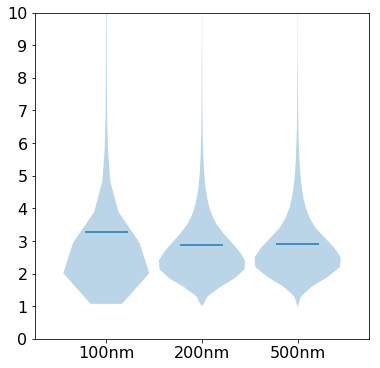

In [21]:
ft.feature_violin(tgroups, points=360, feature='kurtosis', ylim=[0, 10], labels=['100nm', '200nm', '500nm'], nticks=11)

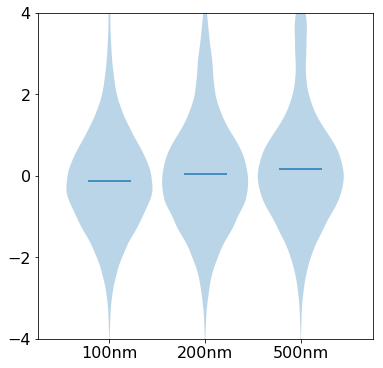

In [27]:
ft.feature_violin(tgroups, points=160, feature=2, ylim=[-4, 4], labels=['100nm', '200nm', '500nm'], nticks=5)

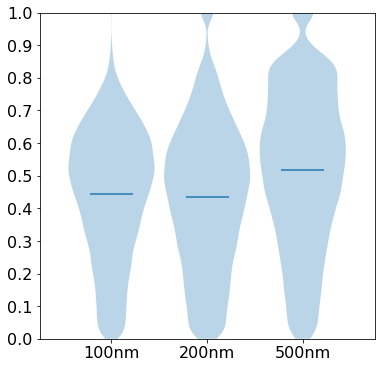

In [26]:
ft.feature_violin(tgroups, points=160, feature='elongation', ylim=[0, 1], labels=['100nm', '200nm', '500nm'], nticks=11)

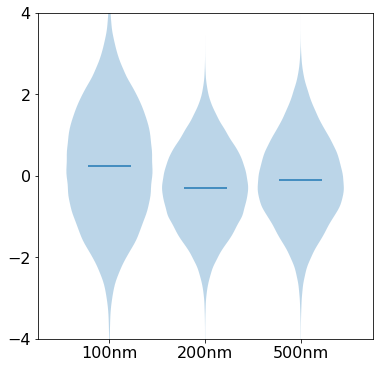

In [29]:
ft.feature_violin(tgroups, points=160, feature=3, ylim=[-4, 4], labels=['100nm', '200nm', '500nm'], nticks=5)

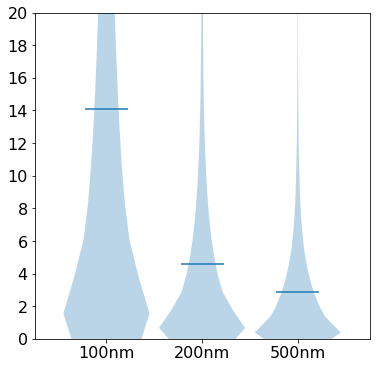

In [31]:
ft.feature_violin(tgroups, points=160, feature='D_fit', ylim=[0, 20], labels=['100nm', '200nm', '500nm'], nticks=11)

In [55]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

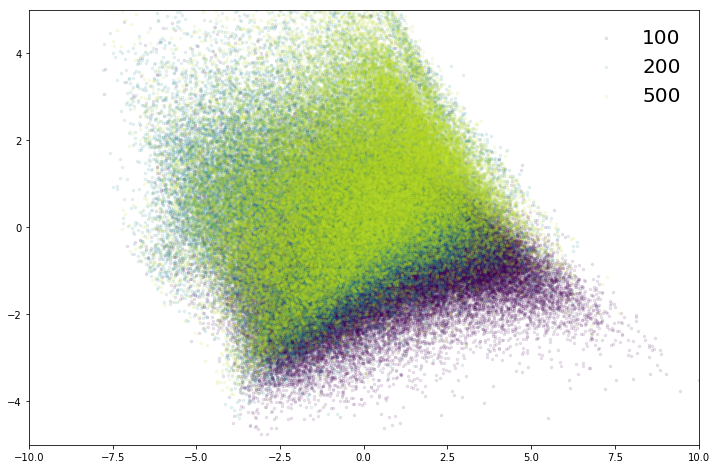

In [238]:
tgroups = {}
xy = {}
tgroups[0] = pcadataset.final[pcadataset.final['Particle Size']==100]
tgroups[1] = pcadataset.final[pcadataset.final['Particle Size']==200]
tgroups[2] = pcadataset.final[pcadataset.final['Particle Size']==500]
color = iter(cm.viridis(np.linspace(0, 0.9, 3)))

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
labels = ['100', '200', '500']
counter = 0
for key in tgroups:
    c = next(color)
    xy = (tgroups[key][0], tgroups[key][1], tgroups[key][2])
    ax1 = plt.scatter(xy[0], xy[1], c=c, s=6, alpha=0.1, label=labels[counter])
    counter = counter + 1
    
plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.legend(fontsize=20, frameon=False)
plt.show()



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

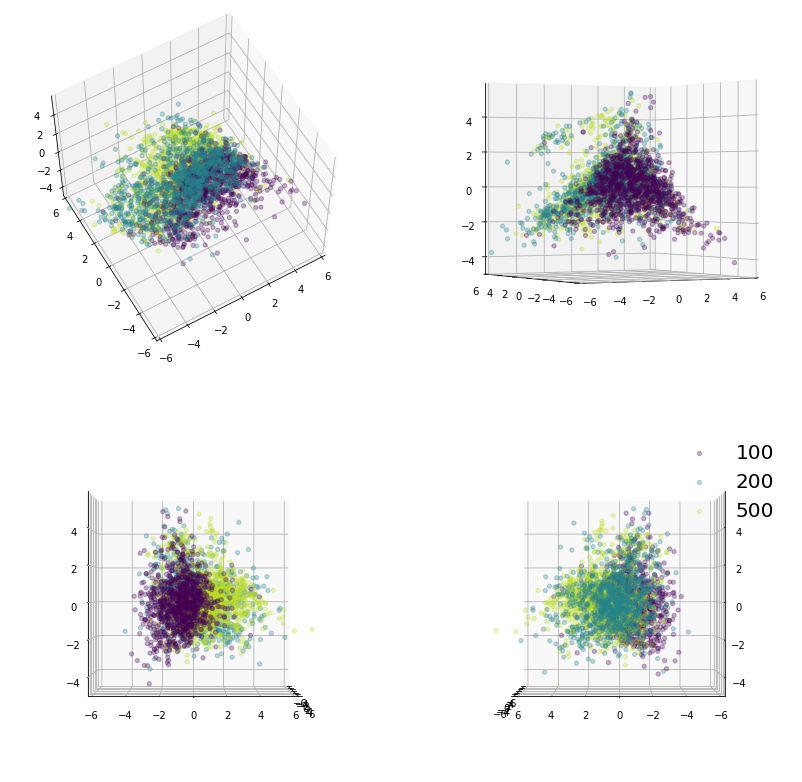

In [114]:
import random

axes = {}
fig = plt.figure(figsize=(14, 14))
axes[1] = fig.add_subplot(221, projection='3d')
axes[2] = fig.add_subplot(222, projection='3d')
axes[3] = fig.add_subplot(223, projection='3d')
axes[4] = fig.add_subplot(224, projection='3d')
color = iter(cm.viridis(np.linspace(0, 0.9, 3)))
angle=240

angle1 = [60, 0, 0, 0]
angle2 = [240, 240, 0, 180]
labels = ['100', '200', '500']
counter = 0
for key in tgroups:
    c = next(color)
    to_plot = random.sample(range(0, len(tgroups[key][0].tolist())), 1000)
    xy = (list(tgroups[key][0].tolist()[i] for i in to_plot), 
          list(tgroups[key][1].tolist()[i] for i in to_plot),
          list(tgroups[key][2].tolist()[i] for i in to_plot))
    acount = 0
    for ax in axes:
        axes[ax].scatter(xy[0], xy[1], xy[2], c=c, s=18, alpha=0.3, label=labels[counter])
        axes[ax].set_xlim3d(-6, 6)
        axes[ax].set_ylim3d(-6, 6)
        axes[ax].view_init(angle1[acount], angle2[acount])
        acount = acount + 1
    counter = counter + 1

plt.legend(fontsize=20, frameon=False)
plt.show()

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

n_neighbors = 15

# import some data to play with
iris = datasets.load_iris()

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

In [ ]:
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

In [116]:
X.shape

(150, 2)

In [233]:
n_neighbors = 6
psizes = [100, 200, 500]


for psize in psizes:
    test = pcadataset.final[pcadataset.final['Particle Size']==psize].values[:, -6:]
    to_plot = np.array(random.sample(range(0, test.shape[0]), 400))
    if psize == 100:
        X = test[to_plot, :]
        y = pcadataset.final[pcadataset.final['Particle Size']==psize]['Particle Size'].values[to_plot]
    else:
        X = np.append(X, test[to_plot, :], axis=0)
        y = np.append(y, pcadataset.final[pcadataset.final['Particle Size']==psize]['Particle Size'].values[to_plot], axis=0)

col = y.shape[0]*[0]
for i in range(0, len(y)):
    if y[i]==100: col[i] = 0 
    elif y[i]==200: col[i] = 1 
    else: col[i] = 2

In [234]:
clf = neighbors.KNeighborsClassifier(n_neighbors)
clf.fit(X, y)

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])


# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure()
# plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# # Plot also the training points
# plt.scatter(X[:, 0], X[:, 1], c=col, cmap=cmap_bold,
#             edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# plt.title("3-Class classification (k = %i)"
#           % (n_neighbors))

# plt.show()

In [235]:
Z2 = clf.predict(X)

In [236]:
correct = np.zeros(y.shape[0])

for i in range(0, y.shape[0]):
    if y[i] == Z2[i]:
        correct[i] = 1

pcorrect = np.average(correct)
print(pcorrect)

0.67


In [231]:
Z2[0:100]

array([100, 100, 100, 200, 100, 200, 200, 100, 100, 500, 100, 500, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 200, 100,
       100, 100, 200, 500, 100, 100, 200, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 500, 100, 100, 500, 200, 100,
       100, 100, 500, 200, 100, 100, 100, 500, 100, 500, 100, 100, 200,
       100, 100, 100, 100, 100, 100, 100, 100, 500, 100, 100, 100, 100,
       200, 200, 100, 200, 100, 100, 100, 100, 200, 100, 100, 100, 200,
       100, 500, 200, 200, 100, 100, 500, 100, 100])

In [237]:
test2 = pcadataset.final.values[:, -6:]
y2 = pcadataset.final['Particle Size'].values

Z3 = clf.predict(test2)
correct = np.zeros(y2.shape[0])

for i in range(0, y2.shape[0]):
    if y2[i] == Z3[i]:
        correct[i] = 1

pcorrect = np.average(correct)
print(pcorrect)

0.579846762667


In [171]:
col = y.shape[0]*[0]
for i in range(0, len(y)):
    if y[i]==100: col[i] = 0 
    elif y[i]==200: col[i] = 1 
    else: col[i] = 2

In [172]:
col

[0,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
